In [40]:
# Import libraries
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from folium import Map, Choropleth, FeatureGroup, LayerControl, CircleMarker
from folium.features import GeoJsonTooltip
import statsmodels.api as sm
from statsmodels.formula.api import glm
from scipy.stats import poisson
import plotly.express as px
from scipy.stats import linregress

In [41]:
# Read in burglaries, chloropleth, and model data
burglaries = gpd.read_file('../data/aggravated_burglaries.geojson')
chloropleth_data = gpd.read_file('../data/chloropleth_data.geojson')
model_data = pd.read_csv('../data/model_data.csv')

In [42]:
# Create chloropleth map with Folium
map_ = Map(location = [36.1627, -86.7816],
           tiles = 'openstreetmap',
           min_zoom = 10)

map_chloropleth = Choropleth(
    geo_data = chloropleth_data,
    data = chloropleth_data,
    columns = ['tract', 'burglaries_per_1000'],
    key_on = 'feature.properties.tract',
    fill_color = 'YlOrRd',
    bins=[0, 1, 2, 5, 10, 21],
    nan_fill_color = 'lightgrey',
    fill_opacity = 0.65,
    line_color = 'black',
    line_weight = 0.1,
    line_opacity = 1,
    name = 'Choropleth Layer',
    legend_name = 'Aggravated Burglary Incidents per 1,000 Residents',
    highlight = True
).add_to(map_)

map_chloropleth.geojson.add_child(
    GeoJsonTooltip(fields = ['tract',
                             'burglaries_count',
                             'burglaries_per_1000',
                             'population',
                             'median_income'
                            ],
                   aliases = ['Census Tract:',
                              'Total Burglaries:',
                              'Burglaries per 1,000:',
                              'Population:',
                              'Median Income:'
                             ],
                   localize = True,
                  )
)

map_burglaries = FeatureGroup(name = 'Marker Layer', show = False)
map_burglaries.add_to(map_)
LayerControl().add_to(map_)

def plot_burglary(burglary):
    
    CircleMarker(location = [burglary.latitude, burglary.longitude],
                 radius = 2.5,
                 weight = 1,
                 fill_color = 'purple', 
                 fill_opacity = 0.75,
                 color = 'white',
                 tooltip = burglary.incident_location,
                ).add_to(map_burglaries)

burglaries.apply(plot_burglary, axis = 1)

display(map_)
map_.save('burglaries_map.html')

<h1>Geospatial API Project</h1>
<h3>October 12, 2021</h3>
<h3><font color = 'purple'>  Purple Pleiosaurauses (Eli, Jacob, Rohit) </font></h3>

In [43]:
burglaries['incident_occurred'] = pd.to_datetime(burglaries['incident_occurred'])
burglaries['hour_of_incident'] = burglaries['incident_occurred'].dt.hour

In [186]:
incident_by_hour = (burglaries
                    .drop_duplicates(subset= 'incident_number')
                    .groupby('hour_of_incident')['offense_description']
                    .count()
                   )

incident_by_hour = pd.DataFrame(incident_by_hour)

incident_by_hour = (incident_by_hour.reset_index()
                    .rename(columns = {'offense_description':'Total Burglaries', 
                                       'hour_of_incident':'Hour'})
                   )

incident_by_hour['Sum_of_burglaries'] = incident_by_hour['Total Burglaries'].sum()
incident_by_hour['Probability of Burglary'] = incident_by_hour['Total Burglaries']/incident_by_hour['Sum_of_burglaries']

prob_dist = px.bar(incident_by_hour, x = incident_by_hour['Hour'],
                   y = incident_by_hour['Probability of Burglary'],
                  title = "Probability of Burglary by Hour",
                  template = 'simple_white')
prob_dist.show()

<h2>Poisson Base Model</h2>

$\log(\lambda) = \beta_0\\$
$\log(Burglaries) = \beta_0 + \log(Population)$

In [210]:
# Build Poisson base model
base_model = glm(formula = 'burglaries_count ~ 1', 
                 data = model_data, 
                 exposure = model_data.population / 1000, 
                 family = sm.families.Poisson()
                ).fit()

display(base_model.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:       burglaries_count   No. Observations:                  157
Model:                            GLM   Df Residuals:                      156
Model Family:                 Poisson   Df Model:                            0
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -607.03
Date:                Tue, 12 Oct 2021   Deviance:                       734.57
Time:                        17:13:10   Pearson chi2:                 1.43e+03
No. Iterations:                     5   Pseudo R-squ. (CS):          1.443e-15
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.1777      0.035      5.084      0.000       0.109       0.246
==============================================================================
"""

<h2>Poisson Base Model Fit</h2>

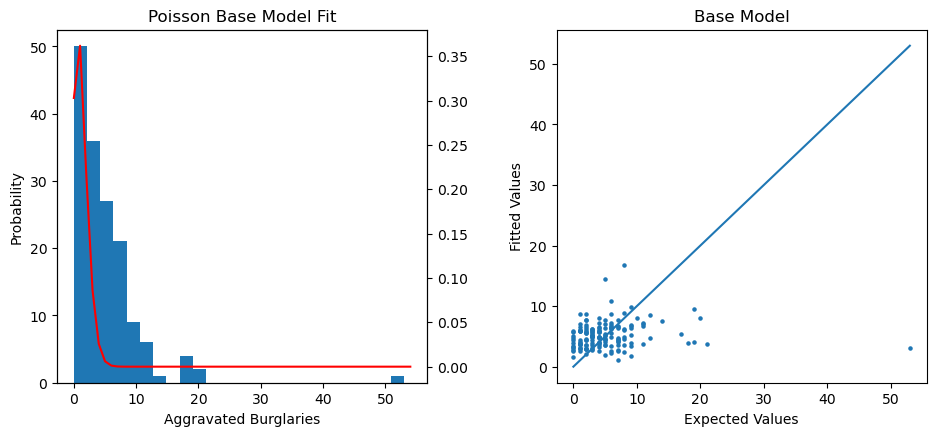

In [214]:
# Plot Poisson base model fit and fitted vs. expected values
model_data['base_fit_values'] = base_model.fittedvalues
intercept = base_model.params
x = np.arange(start = 0, stop = 55)
y = poisson.pmf(k = x, mu = np.exp(intercept))

fig, axs = plt.subplots(1, 2, figsize = (10, 5))

axs[0].hist(model_data['burglaries_count'], bins = 25)
axs[0].twinx().plot(x, y, color = 'red')
axs[0].title.set_text('Poisson Base Model Fit')
axs[0].set_xlabel('Aggravated Burglaries')
axs[0].set_ylabel('Number of Census Tracts')
axs[0].set_ylabel('Probability')

axs[1].scatter(model_data['burglaries_count'], model_data['base_fit_values'], s = 5)
axs[1].plot([0, np.max(model_data['burglaries_count'])], [0, np.max(model_data['burglaries_count'])])
axs[1].title.set_text('Base Model')
axs[1].set_xlabel('Expected Values')
axs[1].set_ylabel('Fitted Values')

fig.tight_layout(pad = 3)

plt.show()

<h2>Poisson Model with Median Income as Predictor Variable</h2>

$\log(\lambda) = \beta_0 + \beta_1 x_1\\$
$\log(Burglaries) = \beta_0 + \beta_1 \times MedianIncome + \log(Population)$

In [211]:
# Build Poisson model with median income as predictor variable
poisson_model = glm(formula = 'burglaries_count ~ median_income', 
                    data = model_data,
                    exposure = model_data.population / 1000,
                    family = sm.families.Poisson()
                   ).fit()

display(poisson_model.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:       burglaries_count   No. Observations:                  157
Model:                            GLM   Df Residuals:                      155
Model Family:                 Poisson   Df Model:                            1
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -532.63
Date:                Tue, 12 Oct 2021   Deviance:                       585.77
Time:                        17:13:44   Pearson chi2:                 1.09e+03
No. Iterations:                     5   Pseudo R-squ. (CS):             0.6124
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         1.2995      0.100     13.046      0.000       1.104       1.495
median_income -1.881e-05    1.7e-06    -11.051      0.000   -2.22e-05   -1.55e-05
=================================================================================
"""

<h2>Poisson Model Fit</h2>

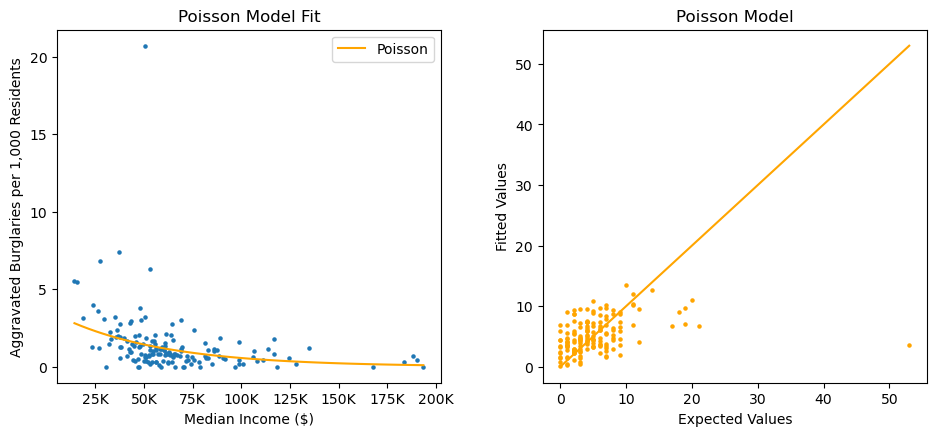

In [190]:
# Plot Poisson model fit
model_data['poisson_fit_values'] = poisson_model.fittedvalues

income_range = np.linspace(np.min(model_data['median_income']), np.max(model_data['median_income']))
poisson_fit = poisson_model.predict({'median_income': income_range})

fig, axs = plt.subplots(1, 2, figsize = (10, 5))

model_data['median_income_in_K'] = model_data['median_income'] / 1000
model_data.plot(kind = 'scatter', x = 'median_income_in_K', y = 'burglaries_per_1000', s = 5, ax = axs[0])
axs[0].plot(income_range / 1000, poisson_fit, color = 'orange')
axs[0].title.set_text('Poisson Model Fit')
axs[0].set_xlabel('Median Income ($)')
axs[0].set_ylabel('Aggravated Burglaries per 1,000 Residents')
axs[0].legend(['Poisson'])

tick = mtick.StrMethodFormatter('{x:.0f}K')
axs[0].xaxis.set_major_formatter(tick) 

axs[1].scatter(model_data['burglaries_count'], model_data['poisson_fit_values'], color = 'orange', s = 5)
axs[1].plot([0, np.max(model_data['burglaries_count'])], [0, np.max(model_data['burglaries_count'])], color = 'orange')
axs[1].title.set_text('Poisson Model')
axs[1].set_xlabel('Expected Values')
axs[1].set_ylabel('Fitted Values')

fig.tight_layout(pad = 3)

plt.show()

<h2>Negative Binomial Model with Median Income as Predictor Variable</h2>

$\log(\lambda) = \beta_0 + \beta_1 x_1\\$
$\log(Burglaries) = \beta_0 + \beta_1 \times MedianIncome + \log(Population)$

In [194]:
# Build negative binomial model with median income as predictor variable
neg_binom_model = glm(formula = 'burglaries_count ~ median_income', 
                      data = model_data,
                      exposure = model_data.population / 1000,
                      family = sm.families.NegativeBinomial()
                     ).fit()

display(neg_binom_model.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:       burglaries_count   No. Observations:                  157
Model:                            GLM   Df Residuals:                      155
Model Family:        NegativeBinomial   Df Model:                            1
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -424.91
Date:                Tue, 12 Oct 2021   Deviance:                       108.27
Time:                        16:53:33   Pearson chi2:                     201.
No. Iterations:                     9   Pseudo R-squ. (CS):             0.1552
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         1.2021      0.223      5.380      0.000       0.764       1.640
median_income  -1.56e-05   3.32e-06     -4.696      0.000   -2.21e-05   -9.09e-06
=================================================================================
"""

<h2>Negative Binomial Model Fit</h2>

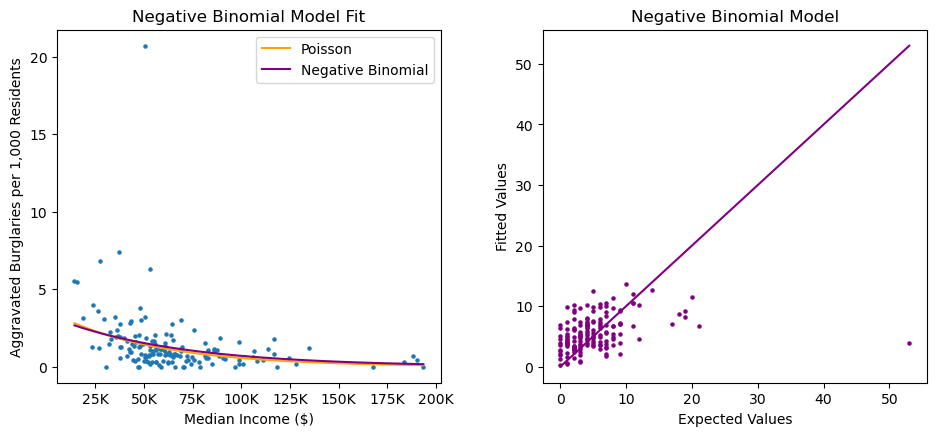

In [209]:
# Plot negative binomial model fit
model_data['neg_binom_fit_values'] = neg_binom_model.fittedvalues

income_range = np.linspace(np.min(model_data['median_income']), np.max(model_data['median_income']))
neg_binom_fit = neg_binom_model.predict({'median_income': income_range})

fig, axs = plt.subplots(1, 2, figsize = (10, 5))

model_data['median_income_in_K'] = model_data['median_income'] / 1000
model_data.plot(kind = 'scatter', x = 'median_income_in_K', y = 'burglaries_per_1000', s = 5, ax = axs[0])
axs[0].plot(income_range / 1000, poisson_fit, color = 'orange')
axs[0].plot(income_range / 1000, neg_binom_fit, color = 'purple')
axs[0].title.set_text('Negative Binomial Model Fit')
axs[0].set_xlabel('Median Income ($)')
axs[0].set_ylabel('Aggravated Burglaries per 1,000 Residents')
axs[0].legend(['Poisson', 'Negative Binomial'])

tick = mtick.StrMethodFormatter('{x:.0f}K')
axs[0].xaxis.set_major_formatter(tick) 

axs[1].scatter(model_data['burglaries_count'], model_data['neg_binom_fit_values'], color = 'purple', s = 5)
axs[1].plot([0, np.max(model_data['burglaries_count'])], [0, np.max(model_data['burglaries_count'])], color = 'purple')
axs[1].title.set_text('Negative Binomial Model')
axs[1].set_xlabel('Expected Values')
axs[1].set_ylabel('Fitted Values')

fig.tight_layout(pad = 3)

plt.show()

<h1>How Do the Models Compare?</h1>

<h2>Checking for Model Overdispersion</h2>

<h4> Estimated Overdispersion = Pearson chi2 / Df Residuals </h4>

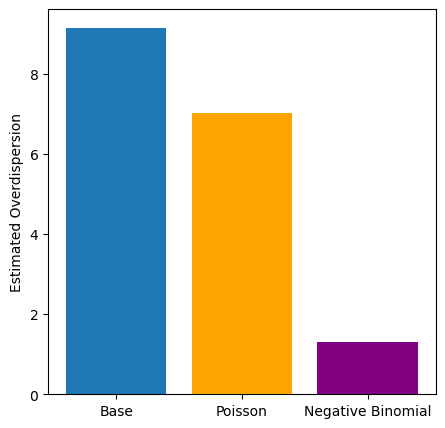

In [196]:
# Plot dispersion ratios
base_model_dispersion = base_model.pearson_chi2 / base_model.df_resid
poisson_model_dispersion = poisson_model.pearson_chi2 / poisson_model.df_resid
neg_binom_model_dispersion = neg_binom_model.pearson_chi2 / neg_binom_model.df_resid

fig, ax = plt.subplots(figsize = (5, 5))

ax.bar(x = ['Base', 'Poisson', 'Negative Binomial'], 
        height = [base_model_dispersion, poisson_model_dispersion, neg_binom_model_dispersion],
        color = ['C0', 'orange', 'purple'])
ax.set_ylabel('Estimated Overdispersion')

plt.show()

<h2>Comparing Model AIC Values</h2>

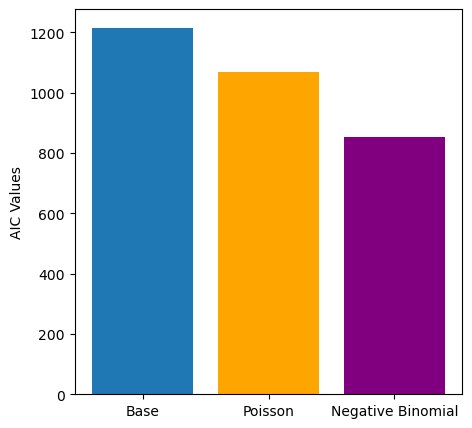

In [187]:
# Plot AIC values
fig, ax = plt.subplots(figsize = (5, 5))

ax.bar(x = ['Base', 'Poisson', 'Negative Binomial'], 
        height = [base_model.aic, poisson_model.aic, neg_binom_model.aic],
        color = ['C0', 'orange', 'purple'])
ax.set_ylabel('AIC Values')

plt.show()

<h2>Pearson Residuals Dependence Plots</h2>

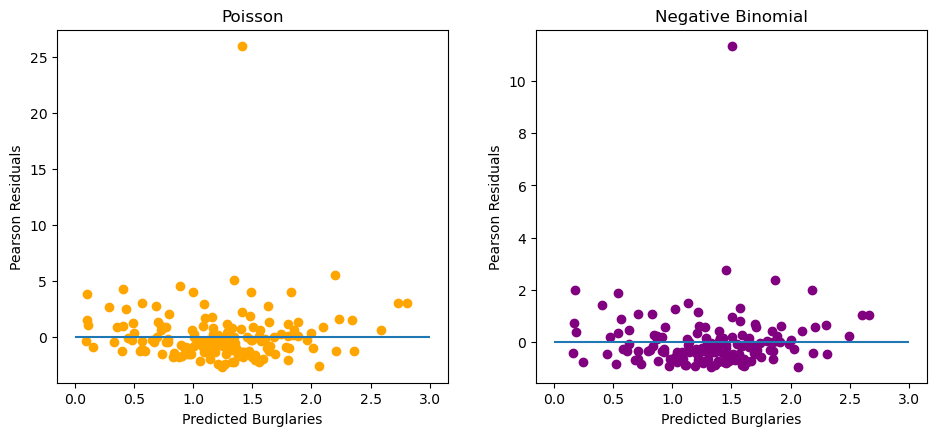

In [189]:
# Residuals Data
poisson_prediction = poisson_model.predict(exog = sm.add_constant(model_data['median_income']))
nbinom_prediction = neg_binom_model.predict(exog = sm.add_constant(model_data['median_income']))
base_model_prediction = base_model.predict(exog = sm.add_constant(model_data['median_income']))

fig, axs = plt.subplots(ncols = 2, nrows=1, figsize = (10,5))

axs[0].scatter(poisson_prediction, poisson_model.resid_pearson, color = 'orange')
axs[0].hlines(0, 0, 3)
axs[0].set_title('Poisson')
axs[0].set_ylabel('Pearson Residuals')
axs[0].set_xlabel('Predicted Burglaries')

axs[1].scatter(nbinom_prediction, neg_binom_model.resid_pearson, color = 'purple')
axs[1].hlines(0, 0, 3)
axs[1].set_title('Negative Binomial')
axs[1].set_ylabel('Pearson Residuals')
axs[1].set_xlabel('Predicted Burglaries');

fig.tight_layout(pad = 3)

plt.show()

In [166]:
R_squared_poisson = linregress(x = poisson_prediction, y=model_data['burglary_rate']).rvalue**2
R_squared_nbinom = linregress(x = nbinom_prediction, y = model_data['burglary_rate']).rvalue**2
R_squared_base = linregress(x = base_model_prediction, y = model_data['burglary_rate']).rvalue**2

<h2>Actual vs. Predicted Values Correlation</h2>

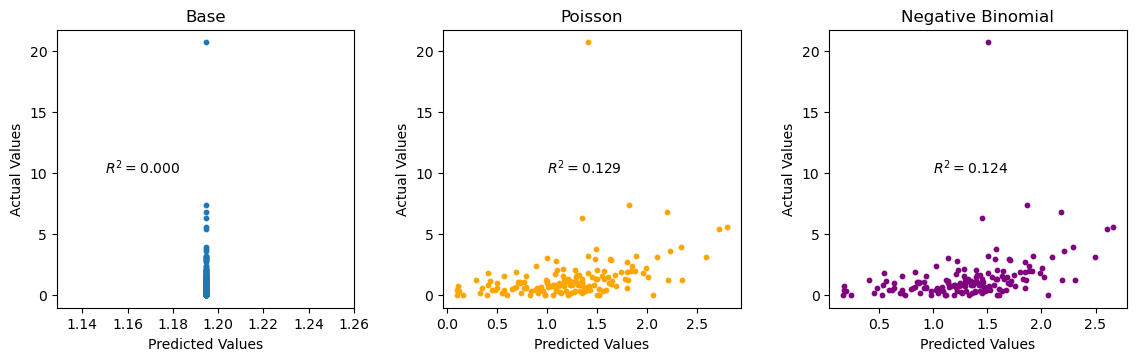

In [213]:
# Actual Value vs. Expected Value

fig, axs = plt.subplots(nrows = 1, ncols = 3, figsize = (12,4.25))

axs[0].scatter(x = base_model_prediction, 
               y = model_data['burglaries_per_1000'],
               s = 10
              )
axs[0].set_title("Base")
axs[0].set_xlabel("Predicted Values")
axs[0].set_ylabel("Actual Values")
axs[0].annotate("$R^2 = {:.3f}$".format(R_squared_base), xy = (1.15,10));

axs[1].scatter(x = poisson_prediction, 
               y = model_data['burglaries_per_1000'],
               s = 10,
               color = 'orange'
              )
axs[1].set_title("Poisson")
axs[1].set_xlabel("Predicted Values")
axs[1].set_ylabel("Actual Values")
axs[1].annotate("$R^2 = {:.3f}$".format(R_squared_poisson), xy = (1,10))

axs[2].scatter(x = nbinom_prediction, 
               y = model_data['burglaries_per_1000'],
               s = 10,
               color = 'purple'
              )
axs[2].set_title("Negative Binomial")
axs[2].set_xlabel("Predicted Values")
axs[2].set_ylabel("Actual Values")
axs[2].annotate("$R^2 = {:.3f}$".format(R_squared_nbinom), xy = (1,10));
fig.tight_layout(pad = 3)

plt.show()